In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
#pm.help()
#pm.reset()
#pm.init() #debug=True)
cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
#cr_cp.info()
#fe_cp.info()

df_jo = pm.df('df_jo')
#df_jo.info()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])

#df_jo = df_jo.drop(columns=['Mes_created_at'])
df_jo_cp = df_jo.copy()

df_jo_cp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32092 non-null  int64          
 1   id_fe                       32092 non-null  int64          
 2   fe_cr_id                    21055 non-null  float64        
 3   user_id                     32092 non-null  int64          
 4   active                      32092 non-null  int64          
 5   created_at                  32092 non-null  datetime64[ns] 
 6   created_at_fe               21055 non-null  datetime64[ns] 
 7   amount                      32092 non-null  float64        
 8   fee                         21055 non-null  float64        
 9   stat_cr                     32092 non-null  object         
 10  stat_fe                     21055 non-null  object         
 11  transfer_type               32092 non-nul

In [3]:
df_jo_cp.head()


,id_cr,id_fe,fe_cr_id,user_id,active,created_at,created_at_fe,amount,fee,stat_cr,...,reco_last_update,updated_at_fe,Mes_created_at,cash_request_received_date,n_fees,n_backs,created_at_slot,created_at_slot_h,created_at_dow,good_user
0,3,0,NaN,47,1,2019-11-19 13:57:53.511561,NaT,1.0,NaN,canceled,...,NaT,NaT,2019-11,NaT,0,0,7,13-Mañana,1,False
1,4,0,NaN,99001309,0,2019-12-09 14:47:35.190714,NaT,100.0,NaN,money_back,...,NaT,NaT,2019-12,NaT,0,1,14,14-Tarde,0,False
2,5,0,NaN,804,1,2019-12-10 19:05:21.596873,NaT,100.0,NaN,rejected,...,NaT,NaT,2019-12,NaT,0,0,14,19-Tarde,1,False
3,6,0,NaN,812,1,2019-12-10 19:05:48.921042,NaT,100.0,NaN,direct_debit_rejected,...,2020-12-18 22:47:48.008850,NaT,2019-12,2019-12-11,0,0,14,19-Tarde,1,False
4,7,0,NaN,191,1,2019-12-10 19:13:35.825460,NaT,100.0,NaN,rejected,...,NaT,NaT,2019-12,NaT,0,0,14,19-Tarde,1,False


In [4]:
df_jo_cp.describe()

,id_cr,id_fe,fe_cr_id,user_id,active,created_at,created_at_fe,amount,fee,to_receive_ini,...,from_date,to_date,updated_at,reco_creation,reco_last_update,updated_at_fe,cash_request_received_date,n_fees,n_backs,created_at_dow
count,32092.000000,32092.000000,21055.000000,3.209200e+04,32092.000000,32092,21055,32092.000000,21055.000000,24147,...,7765,7765,32092,7199,7199,21055,24147,32092.000000,32092.000000,32092.000000
mean,13822.470834,6985.532531,16319.072524,7.967657e+06,0.919824,2020-08-19 09:18:33.707913216,2020-09-21 14:41:09.166412544,83.516733,5.000237,2 days 01:11:32.034121915,...,2020-09-15 16:41:55.547103232,2020-10-06 04:14:39.339139072,2020-11-12 02:56:51.256851200,2020-10-01 02:38:48.797180928,2020-10-31 02:25:35.078318336,2020-10-18 23:08:24.179814400,2020-08-25 12:33:43.406634496,0.760719,2.015985,2.748847
min,3.000000,0.000000,1456.000000,3.400000e+01,0.000000,2019-11-19 13:57:53.511561,2020-05-29 14:27:50.787961,1.000000,5.000000,-1 days +02:01:55.968741,...,2020-05-27 22:00:00,2020-06-09 22:00:00,2019-12-11 09:46:59.779773,2020-03-19 22:10:48.090698,2020-03-31 16:05:16.427692,2020-10-13 14:25:00.740429,2019-12-10 00:00:00,0.000000,0.000000,0.000000
25%,7799.500000,0.000000,11745.500000,1.253700e+04,1.000000,2020-07-13 12:24:07.788202496,2020-08-29 00:02:05.202222080,50.000000,5.000000,0 days 16:03:52.736961500,...,2020-08-06 05:48:27.070000128,2020-09-04 22:00:00,2020-11-01 14:59:45.300140544,2020-08-19 22:25:54.124595968,2020-10-02 22:24:54.526753536,2020-10-13 14:25:08.557196288,2020-07-18 00:00:00,0.000000,0.000000,1.000000
50%,14115.000000,5132.500000,17166.000000,2.700500e+04,1.000000,2020-08-31 01:12:16.739052032,2020-10-03 08:12:48.966279936,100.000000,5.000000,1 days 10:45:33.008224,...,2020-09-25 22:00:00,2020-10-11 16:50:11.884000,2020-12-18 13:09:59.275440384,2020-10-14 22:35:00.223504896,2020-11-06 01:00:04.998823936,2020-10-13 14:25:16.478647040,2020-09-08 00:00:00,0.000000,1.000000,3.000000
75%,19936.250000,13166.250000,21797.000000,5.547150e+04,1.000000,2020-10-08 19:44:31.434317056,2020-10-22 11:40:32.909825536,100.000000,5.000000,2 days 13:35:58.365950,...,2020-10-27 11:00:00,2020-11-05 23:00:00,2020-12-18 13:12:02.949837056,2020-11-12 22:50:00.507954944,2020-12-08 22:06:54.053884928,2020-10-23 08:15:37.924329984,2020-10-15 00:00:00,1.000000,3.000000,4.000000
max,27010.000000,21193.000000,27010.000000,9.903044e+07,1.000000,2020-11-01 23:42:30.847066,2020-11-01 23:43:04.178637,200.000000,10.000000,60 days 17:02:04.753898,...,2021-01-02 22:00:00,2021-01-17 22:00:00,2021-02-12 04:15:27.796931,2021-02-11 23:08:48.764376,2021-02-12 04:15:27.744320,2021-02-10 09:59:06.999173,2020-11-27 00:00:00,15.000000,37.000000,6.000000
std,7416.395576,7070.009173,6656.149646,2.687968e+07,0.271569,NaN,NaN,25.900555,0.034458,2 days 05:14:18.090537826,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.082516,2.530367,1.828468


In [6]:
df_transformado = df_jo_cp.copy()

# Convertir columnas datetime a timestamps
for col in df_transformado.select_dtypes(include=['datetime64']).columns:
    df_transformado[col] = df_transformado[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

# Convertir columnas slot en enteros
df_jo_cp['created_at_slot'] = pd.to_numeric(df_jo_cp['created_at_slot'], errors='coerce').astype('Int64')
df_jo_cp['created_at_dow'] = pd.to_numeric(df_jo_cp['created_at_dow'], errors='coerce').astype('Int64')

# Convertir columna good a 0 si False y 1 si es True
df_jo_cp['good_user'] = df_jo_cp['good_user'].astype(int)

# Filtrar las columnas numéricas (incluyendo las fechas transformadas)
df_numericas = df_transformado.select_dtypes(include=['float64', 'int64'])



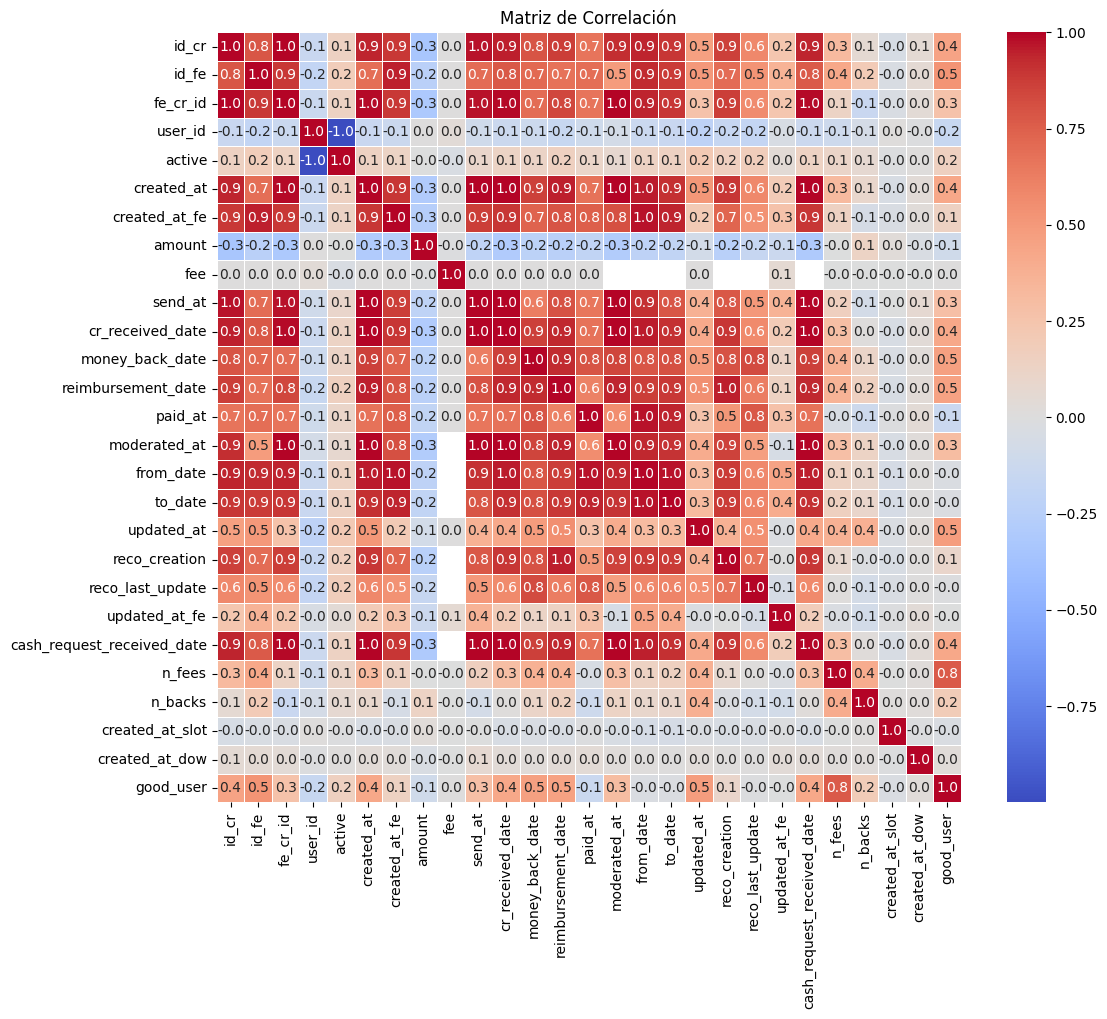

In [8]:
# Calcular la matriz de correlación
matriz_correlacion = df_numericas.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

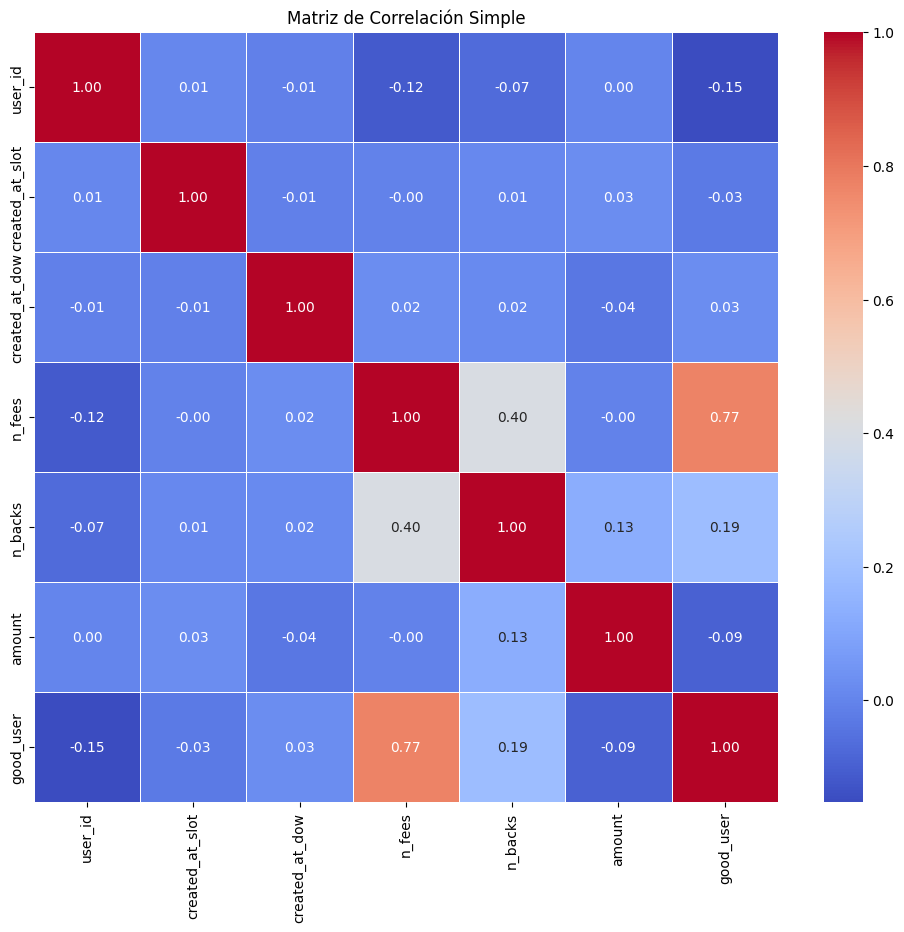

In [9]:
# Lista de columnas que deseas seleccionar
columnas_deseadas = ['user_id', 'created_at_slot', 'created_at_dow' , 'n_fees', 'n_backs', 'amount', 'good_user']

# Crear un nuevo DataFrame con esas columnas
df_simpl = df_jo_cp[columnas_deseadas]

# Calcular la matriz de correlación
m_corr_simpl = df_simpl.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(m_corr_simpl, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación Simple')
plt.show()